# Kalman filter updating

In [1]:
import pandas as pd
import os
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
raw_dir = '../Raw_Data/'
in_dir = '../In_Data/'
out_dir = '../Out_Data/'

if not os.path.exists(out_dir):
    os.mkdir(out_dir)
    
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
dpi = 200

In [2]:
datestart = dt.date(2020, 3, 8)
datetoday = dt.date.today() - dt.timedelta(days=6)
datemodel = dt.date(2020, 3, 16)
dateupdate = dt.date(2020, 3, 13)
dateend = dt.date(2020, 3, 31)

daystart = (datestart-dt.date(2020, 2, 29)).days
daymodel = (datemodel-dt.date(2020, 2, 29)).days
dayupdate = (dateupdate-dt.date(2020, 2, 29)).days
daytoday = (datetoday-dt.date(2020, 2, 29)).days
dayend = (dateend-dt.date(2020, 2, 29)).days

datetodaystr = datetoday.strftime('%Y_%m_%d')
datemodelstr = datemodel.strftime('%Y_%m_%d')

In [3]:
# Read data today.
df_today = pd.read_csv(raw_dir + 'data_au_' + datetodaystr + '.csv', 
                    parse_dates=[0], index_col=[0])

df_today_log = df_today.copy()
df_today_log[df_today_log<=0] = np.nan
df_today_log = df_today_log.apply(lambda x: np.log(x))
df_today_log['day'] = (df_today_log.index-dt.datetime(2020,2,29)).days


In [4]:
# Read model parameters trained on a specific date.
model = pd.read_csv(in_dir + 'para_au_' + datemodelstr + '.csv', index_col='state')

In [5]:
df_obs = df_today[df_today.day>daymodel]
df_obs_log = df_obs.copy()
df_obs_log[df_obs_log<=0] = np.nan
df_obs_log = df_obs_log.apply(lambda x: np.log(x))
df_obs_log['day'] = (df_obs_log.index-dt.datetime(2020,2,29)).days


### Kalman filter algorithm

In [6]:
def run_KF(state_name):
    # read model
    a, b, r2, rmse = model.loc[state_name, ['a','b', 'r2', 'rmse']]
    print(state_name, 'a =', a, 'b=', b)
    # Prediction
    date_now = datestart
    y_init =  a * (daystart-1) + b
    R = np.power(rmse, 2)
    Q = np.power(rmse, 2)
    P = Q
    y_a = y_init
    ys_a = []
    ys_b = []
    ys_obs = []
    Ps_a = []
    Ps_b = []
    dates = []
    while (date_now < dateend):
    # model prediction.
        y_b = y_a + a
        y_a = y_b
        Ps_b.append(P)

        # get obs.
        if date_now < datetoday:
            y_obs = df_today_log.loc[date_now,state_name]
        else:
            y_obs = np.nan
        if date_now > dateupdate:
            # analysis.
            if y_obs is not np.nan:
                # print('state updated on:', date_now)
                P = P + Q
                K = P/(P + R)
                y_a = y_b + K * (y_obs - y_b)
                P = (1-K) * P

        ys_a.append(y_a)
        ys_b.append(y_b)
        ys_obs.append(y_obs)
        Ps_a.append(P)
        dates.append(date_now)
        date_now = date_now + dt.timedelta(days=1)

    y_err = np.sqrt(Ps_a)
    ys_exp_a = np.exp(ys_a)
    ys_exp_b = np.exp(ys_b)
    ys_exp_obs = np.exp(ys_obs)
    ys_exp_err = np.exp(y_err)
   
    ys_log10_a = np.log10(ys_exp_a)
    ys_log10_b = np.log10(ys_exp_b)
    ys_log10_obs = np.log10(ys_exp_obs)
    ys_log10_err = np.log10(ys_exp_err)

    #return dates, ys_exp_a, ys_exp_b, ys_exp_obs, ys_exp_err
    #return dates, ys_a, ys_b, ys_obs, y_err
    return dates, ys_log10_a, ys_log10_b, ys_log10_obs, ys_log10_err

In [7]:
# Test.
dates, ya, yb, yobs, yerr = run_KF('Vic')

Vic a = 0.22505558720327426 b= 0.6665935681009189


### Open-loop
Open-loop is the model forecast without assimiating new observations.

In [8]:
def run_OL(state_name):
    # read model
    a, b, r2, rmse = model.loc[state_name, ['a','b', 'r2', 'rmse']]
    print(state_name, 'a =', a, 'b=', b)
    # Prediction
    days = np.arange(daystart, dayend)
    ys =  a * days + b
    dates = [datestart+dt.timedelta(int(day)) for day in days]
    ys_exp = np.exp(ys)
    ys_log10 = np.log10(ys_exp)
    return days, ys_log10

In [9]:
# Test.
dates_ol, ys_log10_ol = run_OL('Vic')

Vic a = 0.22505558720327426 b= 0.6665935681009189


### Predicting and updating
Predict with the linear regression model.  
Update by assimilating new observations, using KF algorithm.

Total a = 0.19583507428681451 b= 2.7549497289449967
Total a = 0.19583507428681451 b= 2.7549497289449967
NSW a = 0.17484380354363396 b= 2.2777185126275743
NSW a = 0.17484380354363396 b= 2.2777185126275743
Qld a = 0.21232062722075876 b= 0.8220050120018517
Qld a = 0.21232062722075876 b= 0.8220050120018517
Tas a = 0.185212464449698 b= -0.957287102063612
Tas a = 0.185212464449698 b= -0.957287102063612
Vic a = 0.22505558720327426 b= 0.6665935681009189
Vic a = 0.22505558720327426 b= 0.6665935681009189
Total a = 0.19583507428681451 b= 2.7549497289449967
NSW a = 0.17484380354363396 b= 2.2777185126275743
Qld a = 0.21232062722075876 b= 0.8220050120018517
Tas a = 0.185212464449698 b= -0.957287102063612
Vic a = 0.22505558720327426 b= 0.6665935681009189


D:\ProgramData\Anaconda3\envs\field_exp_2018\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


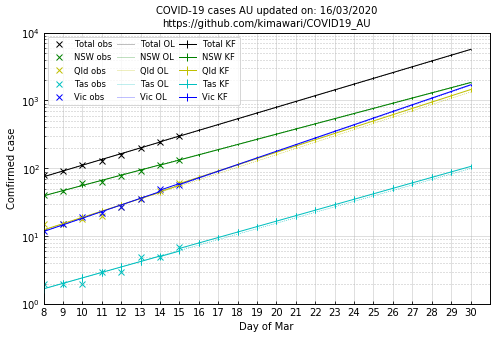

In [10]:
states = ['Total',  'NSW', 'Qld', 'Tas', 'Vic']
color = {'Total': 'k', 'Vic': 'b',  'NSW': 'g',  'Qld': 'y', 'Tas': 'c'}

days = [(d-dt.date(2020, 2, 29)).days for d in dates]
df_predict = pd.DataFrame({'date':dates, 'days': days})

fig = plt.figure(figsize=(8, 5))
ax = plt.gca()

ax.set_yscale('log')
ax.set_ylim(1, np.power(10, 4))
ax.set_yticks([1, 10, 100, 1000, 10000])

ax2= ax.twinx()
ax2.set_ylim(0, 4)
ax2.set_yticks([])
ax2.set_xticks(np.arange(daystart, dayend))
ax2.set_xlim(daystart, dayend)

for state in states:
    dates, ya, yb, yobs, yerr = run_KF(state)
    days_ol, ys_ol = run_OL(state)

    df_predict_state = pd.DataFrame({state:np.power(10, yobs), 
                                     state+'_ol': np.power(10, ys_ol), 
                                     state+'_est': np.power(10, ya)})
    df_predict = pd.concat([df_predict, df_predict_state], axis=1)
    
    # KF updating.
    for i in range (0, len(days)-1):
        ax2.errorbar([days[i], days[i+1]], [ya[i], yb[i+1]], 
                     yerr=[yerr[i], yerr[i+1]], ls='-', lw=1, c=color[state])
    ax2.errorbar([-1,1], [-99,-99], yerr=[1,1], ls='-', lw=1, c=color[state], 
                 label=state+' KF')
    
    # Observation.
    ax2.plot(days, yobs, ls='', marker='x', c=color[state], label=state + ' obs')
    
df_predict.set_index('date', inplace=True)

# Open-loop.
for state in states:
    days_ol, ys_ol = run_OL(state)
    ax2.plot(days_ol, ys_ol, dashes=(0.5, 0.5),lw=0.5, c=color[state], label=state + ' OL')
    



ax.set_title('COVID-19 cases AU updated on: ' + datetoday.strftime('%d/%m/%Y')
             + '\nhttps://github.com/kimawari/COVID19_AU', fontsize=10)
ax.set_xlabel('Day of Mar')
ax.set_ylabel('Comfirmed case')
ax.legend(loc='upper left')

ax.grid(which='major', axis='both', dashes=(0.5,0.5))
ax.grid(which='minor', axis='both', dashes=(0.5, 1))
ax.tick_params(which='both', direction='in')
ax2.tick_params(which='both', direction='in')

plt.legend(loc='upper left', fontsize='small', ncol=3, columnspacing=0.5)
#plt.savefig(out_dir + 'log_kf_au_' + datetodaystr + '.png', dpi=dpi)

## Export prediction.

In [11]:
df_predict_out = df_predict.apply(lambda x: np.round(x), axis=1)
df_predict_out.to_csv(out_dir+'kf_predict_' + datetodaystr + '.csv', float_format='%.0f')

In [12]:
df_predict_out.loc[[datetoday+dt.timedelta(-1)], ['Total', 'Vic', 'NSW', 'Qld', 'Tas']]

,Total,Vic,NSW,Qld,Tas
date,,,,,
2020-03-15,298.0,57.0,133.0,62.0,7.0


In [13]:
df_predict_out.loc[datetoday:dateend, ['Total_est', 'Vic_est', 'NSW_est', 'Qld_est', 'Tas_est']]

,Total_est,Vic_est,NSW_est,Qld_est,Tas_est
date,,,,,
2020-03-16,363.0,73.0,158.0,74.0,8.0
2020-03-17,442.0,91.0,189.0,91.0,10.0
2020-03-18,538.0,114.0,225.0,113.0,12.0
2020-03-19,654.0,143.0,268.0,140.0,14.0
2020-03-20,795.0,179.0,319.0,173.0,17.0
2020-03-21,967.0,224.0,380.0,214.0,20.0
2020-03-22,1177.0,281.0,452.0,264.0,24.0
2020-03-23,1431.0,351.0,539.0,327.0,29.0
2020-03-24,1741.0,440.0,641.0,404.0,35.0
